In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score,accuracy_score

from ViT_model import VisionTransformer

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))

In [ ]:
pd_xela_allfiles = pd.read_csv('data.csv')
pd_sliplabel_allfiles = pd.read_csv('labels.csv')
pd_xela_allfiles.drop(columns=['Unnamed: 0'], inplace=True)
pd_xela_allfiles.head()

In [ ]:
pd_xela_allfiles.info()

In [ ]:
pd_sliplabel_allfiles.drop(columns=['Unnamed: 0'], inplace=True)
pd_sliplabel_allfiles.head()

In [ ]:
pd_sliplabel_allfiles.info()

In [ ]:
col_x = []
col_y = []
col_z = []

In [ ]:
pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = StandardScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


In [ ]:
pd_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)

In [ ]:
print(pd_image.shape)
plt.imshow(pd_image[0][1])
plt.show()

In [ ]:
pd_image = torch.from_numpy(pd_image.astype(np.float32))
pd_label = torch.from_numpy(pd_label.astype(np.float32))

In [ ]:
#split the data into train and test
pd_image_train, pd_image_test, pd_label_train, pd_label_test = train_test_split(pd_image, pd_label, test_size=0.1, shuffle=True)

#split into train and validation
pd_image_train, pd_image_valid, pd_label_train, pd_label_valid = train_test_split(pd_image_train, pd_label_train, test_size=0.3, shuffle = True)


In [ ]:
pd_image_train.shape, pd_label_train.shape

In [ ]:
class seq_dataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len
    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)
    def __getitem__(self, index):
        return torch.flatten(self.X[index:index+self.seq_len], 0,1), self.y[index+self.seq_len-1+self.pred_len]

In [ ]:
SEQ_LEN = 10
PRED_LEN = 5

train_dataset = seq_dataset(pd_image_train, pd_label_train, SEQ_LEN, PRED_LEN)
valid_dataset = seq_dataset(pd_image_valid, pd_label_valid, SEQ_LEN, PRED_LEN)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True, drop_last=True)

In [22]:
for i in train_loader:
    x_try = i[0]
    print(i[0].shape, i[1].shape)
    break

torch.Size([256, 30, 4, 4]) torch.Size([256, 1])


In [25]:
model = VisionTransformer(image_size=4, patch_size=1, in_chans=3*SEQ_LEN, n_classes=1,
                  embed_dim=32, depth=2, n_heads=2, mlp_ratio=1., 
                  qkv_bias=True, p=0.1, attn_p=0.1, proj_p=0.1).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
num_epochs = 300

In [ ]:
#Training and validation loop 
train_loss = []
valid_loss = []

train_accuracy = []
valid_accuracy = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

for epoch in range(num_epochs):
    #Train per batch
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    model.train()
    for (x, y) in (train_loader):
        #Forward pass
        y_pred = model(x.to(device))
        #compute the loss
        l = criterion(y_pred.to(device), y.to(device))
        #empty the gradients
        optimizer.zero_grad()
        #compute the gradient
        l.backward()
        #update the weights
        optimizer.step()
        #append each loss per batch
        train_loss.append(l.item())
        train_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))
        
    

    #calculate and plot the validation loss
    model.eval()
    with torch.no_grad():
        for (x,y) in (valid_loader):
            y_pred = model(x.to(device))
            lv = criterion(y_pred.to(device), y.to(device))
            #append the loss per batch
            valid_loss.append(lv.item())
            #accuracy
            valid_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))
    t_acc.append(np.mean(train_accuracy))
    v_acc.append(np.mean(valid_accuracy))

    print(f'Epoch {epoch+1}, loss = {np.mean(train_loss):.4f} , val_loss = {np.mean(valid_loss):.4f}')
    torch.save(model.state_dict(), 'ViT_checkpoint.pth')

In [ ]:
torch.save(model.state_dict(), 'ViT_n5.pth')

In [ ]:
def plot(metric, title):
    plt.plot(metric)
    plt.title(title)
    plt.show() 

In [ ]:
plot(t_loss, "Train Loss")
plot(v_loss, "Val Loss")

plot(t_acc, "Train Accuracy")
plot(v_acc, "Val Accuracy")

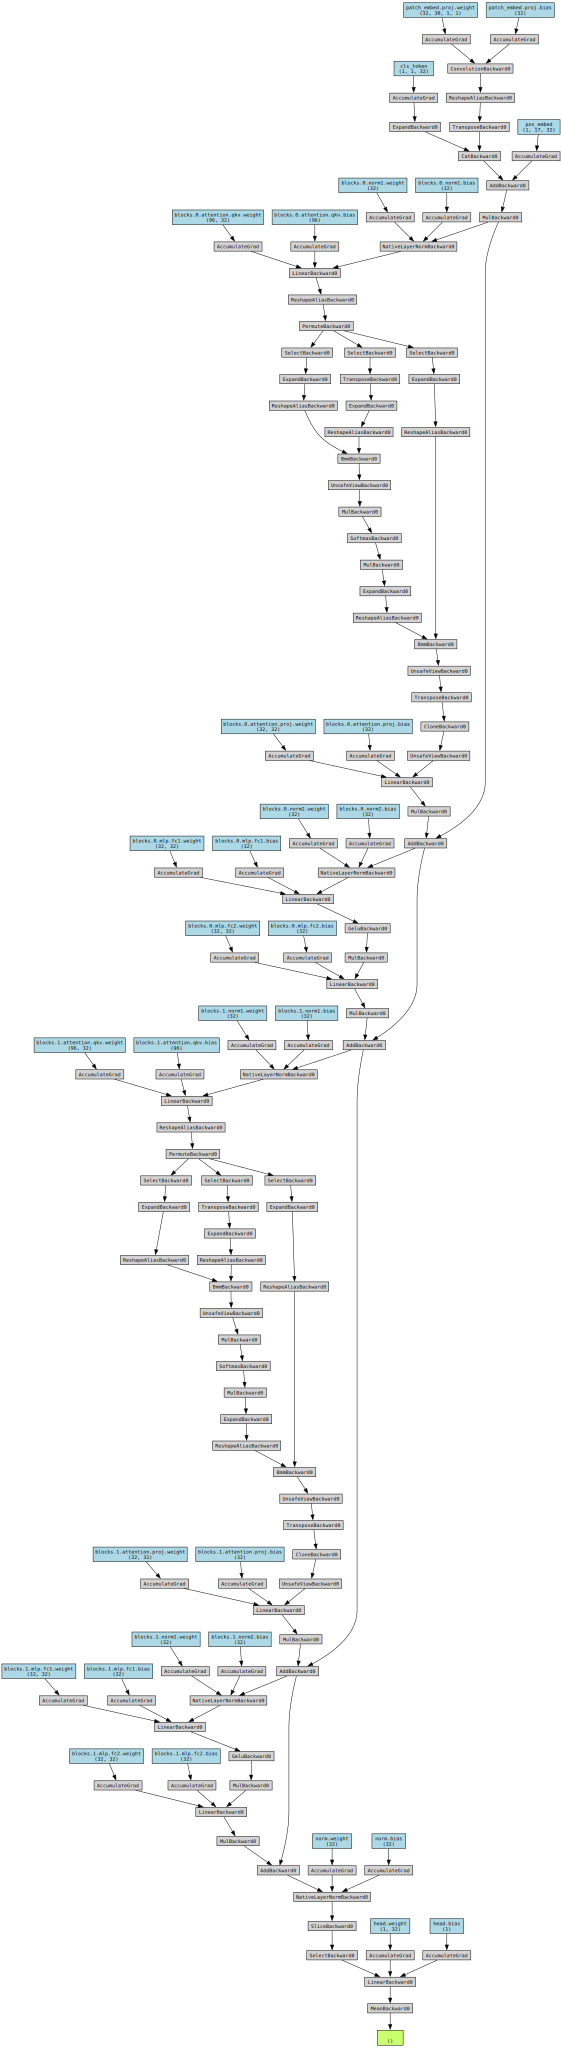

In [29]:
# from torchviz import make_dot
# for i in train_loader:
#     X = i[0][0]
#     X = torch.unsqueeze(X, 0)
#     break

# y = model(X.to(device))

# make_dot(y.mean(), params=dict(model.named_parameters()))

In [34]:
model2 = nn.Linear(4, 3)

X = torch.rand((150, 12))

model2(X).shape

torch.Size([150, 1])